# A/B Test Analysis

### Project Introduction

The project goal is to analyze the online performance of the e-commerce platform and generate new ideas on how to increase sales revenue. To test our new ideas, we will perform an A/B test on the online landing page to see if a different web page would perform better than the current web page.

### Analysis Outline

To complete our goals, we are going to perform the following tasks:

• Performed web page, online traffic, and customer analysis using pandas, numpy, stats, and matplotlib libraries in python.

• Tested hypotheses and made statistical calculations on web page performance.

• Made fact based reccomendations to assist company executives on web page performance.

### Importing Files and Libraries

First, we need to import the libraries we will need for this assignment

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt

Importing files for assignment

In [2]:
try:
    hypotheses_us = pd.read_csv('hypotheses_us.csv',
                                sep=';')
except:
    hypotheses_us = pd.read_csv('/datasets/hypotheses_us.csv',
                                sep=';')

In [3]:
try:
    orders_us = pd.read_csv('orders_us.csv',
                                sep=',')
except:
    orders_us = pd.read_csv('/datasets/orders_us.csv',
                                sep=',')

In [4]:
try:
    visits_us = pd.read_csv('visits_us.csv',
                                sep=',')
except:
    visits_us = pd.read_csv('/datasets/visits_us.csv',
                                sep=',')

### Pre-Processing Data

#### Pre-Processing hypotheses_us

Before we start analyzing the data we need to clean the raw data

In [5]:
hypotheses_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
hypotheses_us.columns

Index(['Hypothesis', 'Reach', 'Impact', 'Confidence', 'Effort'], dtype='object')

First, we are going to convert all the column names into snakecase format for consistency

In [7]:
hypotheses_us = hypotheses_us.rename(columns={'Hypothesis':'hypothesis',
                                              'Reach':'reach',
                                              'Impact':'impact',
                                              'Confidence':'confidence',
                                              'Effort':'effort'})

In [8]:
hypotheses_us.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'effort'], dtype='object')

Checking for duplicated and null values

In [9]:
hypotheses_us.duplicated().sum()

0

In [10]:
hypotheses_us.isnull().sum()

hypothesis    0
reach         0
impact        0
confidence    0
effort        0
dtype: int64

In [11]:
hypotheses_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


The "hypothesis" column was left as an object because there are only 9 entries and overall it does not take up too much data usage

#### Pre-Processing orders_us

In [12]:
orders_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [13]:
orders_us.columns

Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')

First, we are going to convert all the column names into snakecase format for consistency

In [14]:
orders_us = orders_us.rename(columns={'transactionId':'transaction_id',
                                      'visitorId':'visitor_id'})

In [15]:
orders_us.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Checking for duplicated and null values

In [16]:
orders_us.duplicated().sum()

0

In [17]:
orders_us.isnull().sum()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

Then we change can change the data types for "object" columns to conserve data usage

In [18]:
orders_us['date'] = pd.to_datetime(orders_us['date'], format='%Y-%m-%d')

Some visitors may have multiple transactions and during each transaction they may be part of both group A and group B. To fix this we first need to find if there were any such visitors.

In [19]:
multi_group = orders_us.groupby('visitor_id').agg({'group':'count'})

In [20]:
multi_group[multi_group['group'] > 1]

,group
visitor_id,
8300375,2
199603092,5
232979603,2
237748145,5
249864742,3
...,...
4120364173,2
4134830387,2
4186807279,3


It looks like there were several users who are in both groups multiples times due to their repeated transaction on the site. To fix this we will only record their first transaction interaction and remove the others.

In [21]:
orders_us['visitor_id'] = orders_us['visitor_id'].drop_duplicates(keep='first')

User 4256040402 previously had 11 transactions and recorded 11 entries for various groups. However, after removing their last 10 entries, this user now only resides in group B.

In [22]:
orders_us[orders_us['visitor_id'] == 4256040402]

,transaction_id,visitor_id,date,revenue,group
60,1421016313,4.256040e+09,2019-08-16,875.5,B


In [23]:
orders_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1031 non-null   float64       
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   float64       
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 46.9+ KB


The "group" column was left as an object for future calculations. Also, there are not too many entries overall so it does not take too much data usage.

#### Pre-Processing visits_us

In [24]:
visits_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [25]:
visits_us.columns

Index(['date', 'group', 'visits'], dtype='object')

Checking for duplicated and null values

In [26]:
visits_us.duplicated().sum()

0

In [27]:
visits_us.isnull().sum()

date      0
group     0
visits    0
dtype: int64

Converted "date" column object to datetime to save space

In [28]:
visits_us['date'] = pd.to_datetime(visits_us['date'], format='%Y-%m-%d')

In [29]:
visits_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


The "group" column was left as an object for future calculations. Also, there are not too many entries overall so it does not take too much data usage.

### Part 1: Prioritizing Hypotheses

hypotheses_us contains 9 different hypotheses and we are going to rank these by using the ICE and RICE methods

In [30]:
hypotheses_us

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


Now we can start to calculate using the ICE method and sort by descending order

In [31]:
ice_score = (hypotheses_us['impact'] * hypotheses_us['confidence']) / hypotheses_us['effort']

In [32]:
ice_score.sort_values(ascending=False).round(3)

8    16.200
0    13.333
7    11.200
6     8.000
2     7.000
1     2.000
5     1.333
3     1.125
4     1.000
dtype: float64

Next, we use the RICE method and sort by descending order

In [33]:
rice_score = (hypotheses_us['reach'] * hypotheses_us['impact'] * hypotheses_us['confidence']) / hypotheses_us['effort']

In [34]:
rice_score.sort_values(ascending=False)

7    112.0
2     56.0
0     40.0
6     40.0
8     16.2
3      9.0
1      4.0
5      4.0
4      3.0
dtype: float64

Depending on the method, each hypothesis can vary in rank depending on which metric is put into consideration. For example, using the ICE method will indicate that hypothesis 8 would be the best candidate for testing. However, using the RICE method, hypothesis 8 is ranked the fifth best hypothesis to test. This change in rank occurs when the "reach" metric is considered when using the RICE method that was not used during the ICE method. One clear similarity is that hypotheses 1,3,4,5 all rank in the last 4 spots and those hypotheses should definitely not be tested at this time. Also, hypotheses 0 and 7 both rank in the top three using both the ICE and RICE methods, and those two should be taken into consideration on which hypothesis should be used in the A/B test.

### Part 2: A/B Test Analysis

#### 2.1 Graph cumulative revenue by group. Make conclusions and conjectures.

First, we create a new variable that only contains the "date" and "group" columns from the orders_us dataframe

In [35]:
dates_groups = orders_us[['date', 'group']].drop_duplicates()

Next, we take the "dates_group" and use lambda to filter out all rows we are looking for from the orders_us and visits_us dataframe and then we aggregate the data to get the cumulative values for each of our desired columns

In [36]:
orders_agg = dates_groups.apply(lambda x: orders_us[np.logical_and(orders_us['date'] <= x['date'],
                                                                   orders_us['group'] == x['group'])].agg({'date':'max',
                                                                                                           'group':'max',
                                                                                                           'transaction_id':pd.Series.nunique,
                                                                                                           'visitor_id':pd.Series.nunique,
                                                                                                           'revenue':'sum'}), axis=1).sort_values(by=['date','group'])

In [37]:
visits_agg = dates_groups.apply(lambda x: visits_us[np.logical_and(visits_us['date'] <= x['date'],
                                                                   visits_us['group'] == x['group'])].agg({'date':'max',
                                                                                                           'group':'max',
                                                                                                           'visits':'sum'}), axis=1).sort_values(by=['date','group'])

After getting the cumulative data for the orders_us and visits_us dataframe we merge the two dataframes into the "cumulative_data" dataframe and rename the columns

In [38]:
cumulative_data = orders_agg.merge(visits_agg, left_on=['date', 'group'], right_on=['date', 'group'])

In [39]:
cumulative_data.columns = ['date', 'group', 'orders', 'visitors', 'revenue', 'visits']

After creating a dataframe with all the cumulative data we can now look at the cumulative revenue from each group separately (group a and b)

In [40]:
cumulative_rev_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]
cumulative_rev_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

Finally, we can now plot the cumulative revenue of group a and b and compare how each one is performing

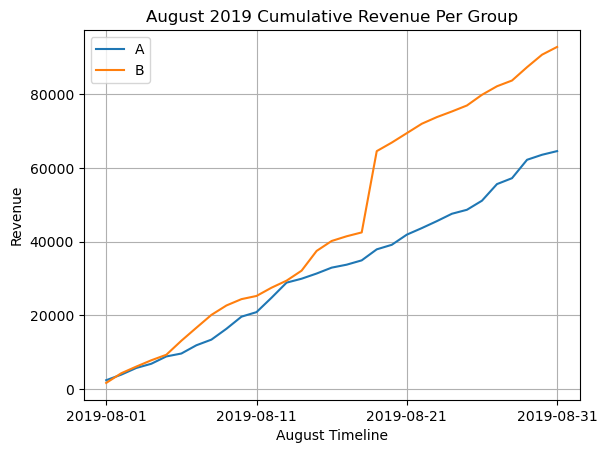

In [41]:
plt.plot(cumulative_rev_a['date'], cumulative_rev_a['revenue'], label='A')
plt.plot(cumulative_rev_b['date'], cumulative_rev_b['revenue'], label='B')
plt.xlabel('August Timeline')
plt.ylabel('Revenue')
plt.xticks(['2019-08-01','2019-08-11', '2019-08-21', '2019-08-31'])
plt.title('August 2019 Cumulative Revenue Per Group')
plt.grid()
plt.legend()
plt.show()

Based on the chart, it illustrates that during the third week of August group B revenue outpaced group A by a significant margin for a few days before reverting back to the mean growth pace

#### 2.2 Graph cumulative average order size by group. Make conclusions and conjectures.

To find the average order size per group we divide the cumulative revenue by the cumulative orders for both groups

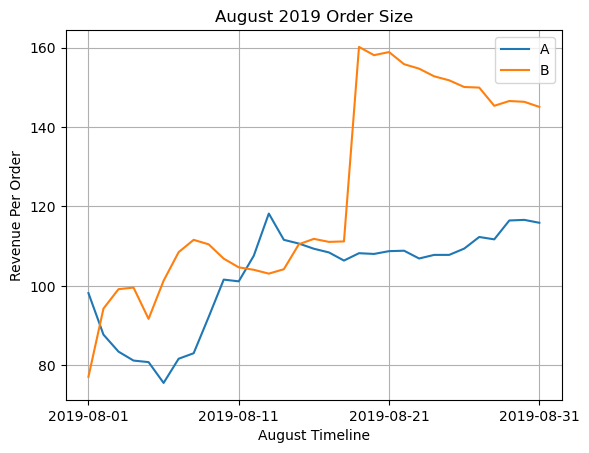

In [42]:
plt.plot(cumulative_rev_a['date'], cumulative_rev_a['revenue'] / cumulative_rev_a['orders'], label='A')
plt.plot(cumulative_rev_b['date'], cumulative_rev_b['revenue'] / cumulative_rev_b['orders'], label='B')
plt.xlabel('August Timeline')
plt.ylabel('Revenue Per Order')
plt.xticks(['2019-08-01','2019-08-11', '2019-08-21', '2019-08-31'])
plt.title('August 2019 Order Size')
plt.grid()
plt.legend()
plt.show()

Based on the graph it shows that during the third week of August, there was a sharp increase in order size for group B. However, it should be noted that after the sharp increase for group B the revenue per order slowly started to decrease back to the mean order size as the growth in order size was a one-time event for that month.

#### 2.3 Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.

Before finding the difference in cumulative average order size, we need to merge the two cumulative revenue groups into one dataframe

In [43]:
cumulative_rev_merged = cumulative_rev_a.merge(cumulative_rev_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [44]:
cumulative_rev_merged.columns

Index(['date', 'revenueA', 'ordersA', 'revenueB', 'ordersB'], dtype='object')

Converting the column names into snakecase format for consistancy

In [45]:
cumulative_rev_merged = cumulative_rev_merged.rename(columns={'revenueA':'revenue_a',
                                                              'ordersA':'orders_a',
                                                              'revenueB':'revenue_b',
                                                              'ordersB':'orders_b'})

In [46]:
cumulative_rev_merged.columns

Index(['date', 'revenue_a', 'orders_a', 'revenue_b', 'orders_b'], dtype='object')

After combining the two pior dataframes into one we can now calculate and graph the difference in cumulative average order sizes

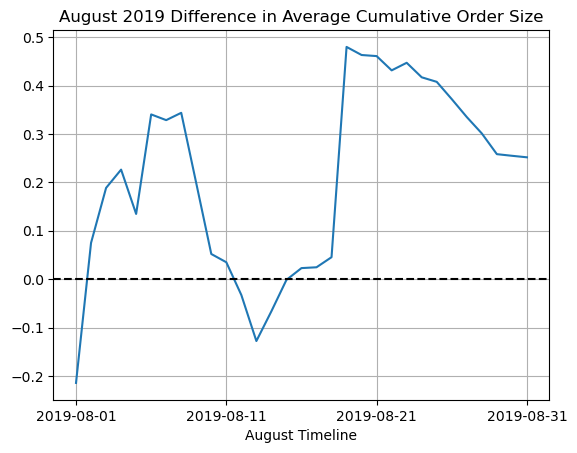

In [47]:
plt.plot(cumulative_rev_merged['date'], 
         (cumulative_rev_merged['revenue_b'] / cumulative_rev_merged['orders_b']) 
         / (cumulative_rev_merged['revenue_a'] / cumulative_rev_merged['orders_a']) - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('August Timeline')
plt.xticks(['2019-08-01','2019-08-11', '2019-08-21', '2019-08-31'])
plt.title('August 2019 Difference in Average Cumulative Order Size')
plt.grid()
plt.show()

Based on the data, it shows that Group B performed better in the month of August than Group A. However, there were times during this month when Group B underperformed Group A, and after the large third-week spike in revenue group B has been slowly giving way to Group A. This trend should be analyzed on a larger timescale to see a more consistent performance from these groups. 

#### 2.4 Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.

First, we need to calculate the conversion rate for the cumulative_data dataframe

In [48]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

After calculating for the conversion rate, we divide the dataframe into the two group types

In [49]:
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

Then we graph the two different groups

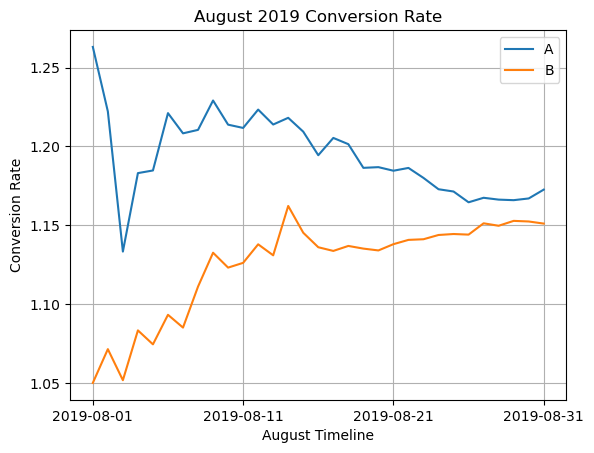

In [50]:
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.xlabel('August Timeline')
plt.ylabel('Conversion Rate')
plt.xticks(['2019-08-01','2019-08-11', '2019-08-21', '2019-08-31'])
plt.title('August 2019 Conversion Rate')
plt.grid()
plt.legend()
plt.show()

Based on the graph, it appears that there was an issue early on with a peeking problem. However, as more data was added, it showed that group A trended down from its peak and started to trend sideways while group B consistently trended up throughout the month. In the end, both groups were very close to each other in conversion rates and this trend should be analyzed over a larger timeframe.

#### 2.5 Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.

First, we need to create a new dataframe that contains only users and orders

In [51]:
orders_per_user = orders_agg.drop(['date', 'group', 'revenue'], axis=1).groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique})

In [52]:
orders_per_user.columns = ['users', 'orders']

After creating the new dataframe we can now graph it on a scatter plot

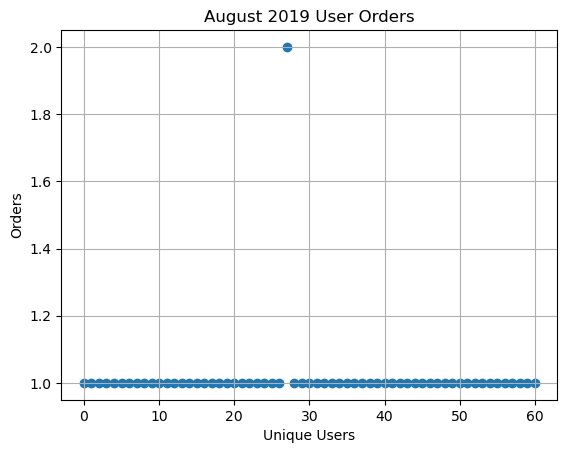

In [53]:
x_values = pd.Series(range(0,len(orders_per_user)))
plt.scatter(x_values, orders_per_user['orders']) 
plt.xlabel('Unique Users')
plt.ylabel('Orders')
plt.title('August 2019 User Orders')
plt.grid()
plt.show()

Based on the scatter plot, it shows that there was one user who ordered twice while every other user ordered once

#### 2.6 Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

To calculate the percentile we have to use numpy and the percentile method

In [54]:
np.percentile(orders_per_user['orders'], [95, 97, 99])

array([1. , 1. , 1.4])

Based on the output, it shows that orders start to increase when we get to around the 99th percentile

In [55]:
max_orders = int(np.percentile(orders_per_user['orders'], [99]))

For future calculations we will record this percentile as an integer

#### 2.7 Plot a scatter chart of order prices. Make conclusions and conjectures.

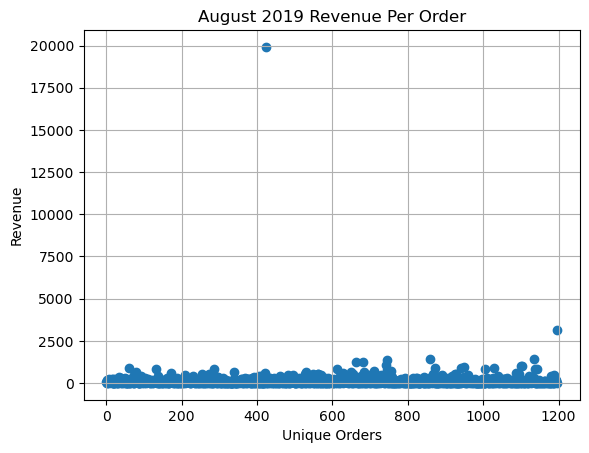

In [56]:
x_values = pd.Series(range(0,len(orders_us['revenue'])))
plt.scatter(x_values, orders_us['revenue']) 
plt.xlabel('Unique Orders')
plt.ylabel('Revenue')
plt.title('August 2019 Revenue Per Order')
plt.grid()
plt.show()

Based on this scatter plot, it shows that a majority of orders are under $1000 with a few heavy outliers ranging from $1000-$20000

#### 2.8 Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

To calculate the percentile we have to use numpy and the percentile method

In [57]:
np.percentile(orders_us['revenue'], [95, 98.5, 99])

array([435.54 , 816.67 , 900.904])

Based on the output, it shows that when you enter the 99th percentile the revenue per order started to increase dramatically

In [58]:
max_revenue = int(np.percentile(orders_us['revenue'], [99]))

For future calculations we will record this percentile as an integer

#### 2.9 Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.

##### Background information on testing methods.

The null hypothesis (H0) is a statement where there is no significant difference between group A and group B. The alternative hypothesis (H1) is a statement where there is significant difference between group A and group B. To see if we we reject the null hypothesis or embrace the alternative hypothesis we will calculate the p-value of the dataset using the mann-whitney test.

If: H0 (Null): p-value > 0.05 
Then: we fail to reject the null hypothesis and keep the original web page (group A) 

If: H1 (Alternative): p-value <= 0.05 
Then: we have reason to reject the null hypothesis and embrace the alternative hypothesis (group B)

First, we need to filter the raw data (orders_us) by group types. Then we group the remaining data by users and count the unique order ids. We do this for group A and B.

In [59]:
orders_group_a = orders_us[orders_us['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique})

In [60]:
orders_group_a.columns = ['user_id', 'orders']

In [61]:
orders_group_b = orders_us[orders_us['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique})

In [62]:
orders_group_b.columns = ['user_id', 'orders']

Next, we create a sample for each group to count how many orders each visitor ordered. This also includes visitors who did not make an order making their order count 0.

In [63]:
sample_a = pd.concat([orders_group_a['orders'], pd.Series(0, index=np.arange(visits_us[visits_us['group'] == 'A']['visits'].sum() 
                                                                             - len(orders_group_a['orders'])), name='orders')], axis=0)

In [64]:
sample_b = pd.concat([orders_group_b['orders'], pd.Series(0, index=np.arange(visits_us[visits_us['group'] == 'B']['visits'].sum() 
                                                                             - len(orders_group_b['orders'])), name='orders')], axis=0)

Now we can calculate to see where the p-value is compated the significance level of 0.05

In [65]:
print('P-Value:', (st.mannwhitneyu(sample_a, sample_b)[1]).round(3))

P-Value: 0.016


Based on the mann-whitney test there is cause for us to reject the null hypothesis since 0.016 < 0.05 (the significance level). This means we should move on to the alternative hypothesis for the better conversion rate based on the raw data.

In [66]:
print(f'difference: {(sample_b.mean() / sample_a.mean() - 1).round(3)}')

difference: 0.159


For the second output, group B displays a 15.9% increase from group A based on the raw data

#### 2.10 Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.

To calculate the statistical significance of the difference the average order size, we will need to use the mann-whitney test again

In [67]:
print('P-Value:', (st.mannwhitneyu(orders_us[orders_us['group'] == 'A']['revenue'],
                                   orders_us[orders_us['group'] == 'B']['revenue'])[1]).round(3))

P-Value: 0.692


Based on this output, we cannot reject the null hypothesis since 0.692 > 0.05. From the raw data there is no proof that the alternative hypothesis is significantly better than the null hypothesis when it comes to average order size.

In [68]:
print(f'''difference: {(orders_us[orders_us['group'] == 'B']['revenue'].mean() 
                      / orders_us[orders_us['group'] == 'A']['revenue'].mean() - 1).round(3)}''')

difference: 0.252


Based on this raw data, group B does 25.2% better than group A.

#### 2.11 Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.

Now we do the same calculation as earlier but before this calculation, we must filter our raw data for the outlier’s data points that are skewing our data. First, we can filter the orders_group_a and b for orders that are more than one (this is from the output from the scatter plot we made earlier)

In [69]:
outlier_orders_size = pd.concat([orders_group_a[orders_group_a['orders'] > max_orders]['user_id'],
                                 orders_group_b[orders_group_b['orders'] > max_orders]['user_id']], axis=0)

Then we filter for orders over $900 (this is from the 99th percentile we calculated earlier using np.percentile())

In [70]:
outlier_orders_price = orders_us[orders_us['revenue'] > max_revenue]['visitor_id']

Then we can combine this filters into one dataframe

In [71]:
outlier_users = (pd.concat([outlier_orders_size, outlier_orders_price], axis=0).drop_duplicates().sort_values())

Same as before we create a sample for each group to count how many orders each visitor ordered. This also includes visitors who did not make an order making their order count 0.

In [72]:
sample_a_filtered = pd.concat([orders_group_a[np.logical_not(orders_group_a['user_id'].isin(outlier_users))]['orders'],
                               pd.Series(0, index=np.arange(visits_us[visits_us['group'] == 'A']['visits'].sum()
                                                            - len(orders_group_a['orders'])), name='orders')], axis=0)

In [73]:
sample_b_filtered = pd.concat([orders_group_b[np.logical_not(orders_group_b['user_id'].isin(outlier_users))]['orders'],
                               pd.Series(0, index=np.arange(visits_us[visits_us['group'] == 'B']['visits'].sum() 
                                                            - len(orders_group_b['orders'])), name='orders')], axis=0)

Now we can conduct the mann-whitney test on the new filtered data

In [74]:
print('P-Value:', (st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]).round(3))

P-Value: 0.012


Based on the p-value, we should reject the null hypothesis because 0.012 < 0.05 significance level. This means that with the filtered data the alternative hypothesis performs better than the null hypothesis when it comes to the conversion rate.

In [75]:
print(f'difference: {(sample_b_filtered.mean() / sample_a_filtered.mean() - 1).round(3)}')

difference: 0.168


With the filtered data group B performs 16.8% better than group A

#### 2.12 Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.

Again we can use the mann-whitney test to see if we accept or reject the null hypothesis but this time using the filtered data

In [76]:
print('P-Value:', (st.mannwhitneyu(orders_us[np.logical_and(orders_us['group'] == 'A',
                                                            np.logical_not(orders_us['visitor_id'].isin(outlier_users)))]['revenue'],
                                   orders_us[np.logical_and(orders_us['group'] == 'B',
                                                            np.logical_not(orders_us['visitor_id'].isin(outlier_users)))]['revenue'])[1]).round(3))

P-Value: 0.91


Based on the filtered data, we fail to reject the null hypothesis since 0.91 > 0.05 when comparing the average order size.

In [77]:
print(f'''difference: {(orders_us[np.logical_and(orders_us['group'] == 'B', np.logical_not(orders_us['visitor_id'].isin(outlier_users)))]['revenue'].mean() 
                        / orders_us[np.logical_and(orders_us['group'] == 'A', np.logical_not(orders_us['visitor_id'].isin(outlier_users)))]['revenue'].mean() - 1).round(3)}''')

difference: 0.005


Using the filtered data, group B is about 0.5% better than group A

#### 2.13 Make a decision based on the test results. The possible decisions are: 

#### 1. Stop the test, consider one of the groups the leader. 

#### 2. Stop the test, conclude that there is no difference between the groups. 

#### 3. Continue the test.

Based on our goal to increase online revenue, we should stop the test and switch to the the alternative hypothesis (H1).

### Conclusion

We can conclude that the alternative hypothesis (H1) is the better web page based on the statistical significance difference between groups A and B. When comparing groups, A and B, group B throughout our tests showed an increase in our metrics when compared to group A. The statistical difference in the conversion rate and order size there was always a positive increase in both metrics using both the raw data and the filtered data. In addition, the p-value was > 0.05 for the conversion rate test in both the raw and filtered data telling us to reject the null hypothesis (H0). At worst the alternative hypothesis will perform just as well as the current web page. Also, before the A/B test, there was no indication of how large our sample size should be nor how long we were going to keep the test running. If we were to keep the test running, we would be picking an arbitrary date to end which could skew the data where we get no conclusive results.